<a href="https://colab.research.google.com/github/oliia/BootcampDatathons/blob/main/Datathon1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://dphi.tech/practice/challenge/49#data

In [164]:
import numpy as np
import pandas as pd
from  matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from sklearn.pipeline import Pipeline

# Helpers

In [165]:
def plot_data(X, y): 
	plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15) 
	plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r') 
	plt.legend() 
	return plt.show()

In [216]:
# Test data - encoding categorical columns 
# Remove additional columns 
def remove_add_col(df_test_processed, cat_columns, cat_dummies) :
  
  '''
  df_test_processed dataframe with new data, encoded  
  cat_columns list of the name of categorical columns 
  cat_dummies list of all encoded columns, one for each encoding, after processing train dataframe
  ''' 
  
  for col in df_test_processed.columns:
      if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
          print("Removing additional feature {}".format(col))
          df_test_processed.drop(col, axis=1, inplace=True)
      
  return df_test_processed

In [217]:
# Test data - encoding categorical columns
# Adds missing columns 

def add_missing_columns(df_test_processed, cat_dummies, processed_columns):


  for col in cat_dummies:
    if col not in df_test_processed.columns:
        print("Adding missing feature {}".format(col))
        df_test_processed[col] = 0
   
  # reorder columns 
  df_test_processed = df_test_processed[processed_columns]

  return df_test_processed

# Training data and EDA

In [2]:
insurance_data  = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Training_set_label.csv" )

In [5]:
insurance_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48260 entries, 0 to 48259
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                48260 non-null  object 
 1   Agency Type           48260 non-null  object 
 2   Distribution Channel  48260 non-null  object 
 3   Product Name          48260 non-null  object 
 4   Duration              48260 non-null  int64  
 5   Destination           48260 non-null  object 
 6   Net Sales             48260 non-null  float64
 7   Commision (in value)  48260 non-null  float64
 8   Gender                13899 non-null  object 
 9   Age                   48260 non-null  int64  
 10  Claim                 48260 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 4.1+ MB


In [59]:
insurance_data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,29,0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,36,0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,25,0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,24,0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,23,0


In [ ]:
insurance_data.groupby('Agency')['Claim'].value_counts()

# Missing data

In [251]:
def dropping_cols(data_test):
  
  ''' 
  '''

  data_test.drop(columns = ['Commision (in value)', 'Gender'], inplace = True)

  return data_test

## Numerical

In [70]:
# numerical
insurance_data[insurance_data['Duration']==0].count()

Agency                  49
Agency Type             49
Distribution Channel    49
Product Name            49
Duration                49
Destination             49
Net Sales               49
Commision (in value)    49
Age                     49
Claim                   49
dtype: int64

In [247]:
((insurance_data['Commision (in value)'] == 1) | (insurance_data['Commision (in value)'] == 0)).value_counts()

True     26784
False    21476
Name: Commision (in value), dtype: int64

In [249]:
insurance_data.drop(columns = 'Commision (in value)', inplace = True)

## Categorical

In [24]:
# categorical 
# Null values in Gender column
insurance_data['Gender'].value_counts()

M    7137
F    6762
Name: Gender, dtype: int64

In [29]:
# Gender has >20% of missing values, and doesn't seem to be a strong predictor. Thus I drop the column.
insurance_data.drop(columns = 'Gender', inplace = True)

In [43]:
# Is my dataset balanced?
insurance_data['Claim'].value_counts()
# see solution later

0    47552
1      708
Name: Claim, dtype: int64

In [31]:
insurance_data.describe()

,Duration,Net Sales,Commision (in value),Age,Claim
count,48260.000000,48260.000000,48260.000000,48260.000000,48260.000000
mean,49.546602,40.747647,9.811735,39.927269,0.014671
std,104.828147,48.823217,19.695339,14.027329,0.120231
min,-2.000000,-389.000000,0.000000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000,0.000000
50%,22.000000,27.000000,0.000000,36.000000,0.000000
75%,53.000000,48.000000,11.630000,43.000000,0.000000
max,4881.000000,666.000000,262.760000,118.000000,1.000000


# Preprocessing pipeline 

In [252]:
# Creating data 
y = insurance_data['Claim']
X = insurance_data.drop(columns = 'Claim', inplace = False)

In [253]:
X.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Age
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,29
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,36
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,25
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,24
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,23


## Categorical data

In [199]:
cat = X.select_dtypes(['object']).columns

In [202]:
X.select_dtypes(['object']).columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Destination'],
      dtype='object')

In [203]:
# Get the categorical columns
cat_columns = X.select_dtypes(['object']).columns

In [193]:
result.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620,2621,2622,2623,2624,2625,2626,2627,2628,2629,2630,2631,2632,2633,2634,2635,2636,2637,2638,2639,2640,2641,2642,2643
0,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,61,UNITED KINGDOM,19.8,11.88,29,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EPX,Travel Agency,Online,Cancellation Plan,93,NEW ZEALAND,63.0,0.00,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EPX,Travel Agency,Online,2 way Comprehensive Plan,22,UNITED STATES,22.0,0.00,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C2B,Airlines,Online,Silver Plan,14,SINGAPORE,54.5,13.63,24,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EPX,Travel Agency,Online,Cancellation Plan,90,VIET NAM,10.0,0.00,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
# Encode categorical data 
X_enc = pd.get_dummies(X, drop_first = True, prefix_sep="__", columns=cat_columns)

In [257]:
X_enc.head()

,Duration,Net Sales,Age,Agency__ART,Agency__C2B,Agency__CBH,Agency__CCR,Agency__CSR,Agency__CWT,Agency__EPX,Agency__JWT,Agency__JZI,Agency__KML,Agency__LWC,Agency__RAB,Agency__SSI,Agency__TST,Agency__TTW,Agency Type__Travel Agency,Distribution Channel__Online,Product Name__2 way Comprehensive Plan,Product Name__24 Protect,Product Name__Annual Gold Plan,Product Name__Annual Silver Plan,Product Name__Annual Travel Protect Gold,Product Name__Annual Travel Protect Platinum,Product Name__Annual Travel Protect Silver,Product Name__Basic Plan,Product Name__Bronze Plan,Product Name__Cancellation Plan,Product Name__Child Comprehensive Plan,Product Name__Comprehensive Plan,Product Name__Gold Plan,Product Name__Individual Comprehensive Plan,Product Name__Premier Plan,Product Name__Rental Vehicle Excess Insurance,Product Name__Silver Plan,Product Name__Single Trip Travel Protect Gold,Product Name__Single Trip Travel Protect Platinum,Product Name__Single Trip Travel Protect Silver,...,Destination__PORTUGAL,Destination__PUERTO RICO,Destination__QATAR,Destination__REPUBLIC OF MONTENEGRO,Destination__REUNION,Destination__ROMANIA,Destination__RUSSIAN FEDERATION,Destination__SAMOA,Destination__SAUDI ARABIA,Destination__SERBIA,Destination__SEYCHELLES,Destination__SINGAPORE,Destination__SLOVENIA,Destination__SOLOMON ISLANDS,Destination__SOUTH AFRICA,Destination__SPAIN,Destination__SRI LANKA,Destination__SWEDEN,Destination__SWITZERLAND,"Destination__TAIWAN, PROVINCE OF CHINA","Destination__TANZANIA, UNITED REPUBLIC OF",Destination__THAILAND,Destination__TIBET,Destination__TRINIDAD AND TOBAGO,Destination__TUNISIA,Destination__TURKEY,Destination__TURKMENISTAN,Destination__UGANDA,Destination__UKRAINE,Destination__UNITED ARAB EMIRATES,Destination__UNITED KINGDOM,Destination__UNITED STATES,Destination__URUGUAY,Destination__UZBEKISTAN,Destination__VANUATU,Destination__VENEZUELA,Destination__VIET NAM,"Destination__VIRGIN ISLANDS, U.S.",Destination__ZAMBIA,Destination__ZIMBABWE
0,61,19.8,29,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,93,63.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,22,22.0,25,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,14,54.5,24,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,90,10.0,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [258]:
# save the dummy columns 
cat_dummies = [col for col in X_enc 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

In [ ]:
cat_dummies

In [259]:
processed_columns = list(X_enc.columns[:])

In [ ]:
processed_columns

## Numerical data 

In [97]:
# get numeric data
num_d = X.select_dtypes(exclude=['object'])

In [102]:
print(num_d)

       Duration  Net Sales  Commision (in value)  Age
0            61       19.8                 11.88   29
1            93       63.0                  0.00   36
2            22       22.0                  0.00   25
3            14       54.5                 13.63   24
4            90       10.0                  0.00   23
...         ...        ...                   ...  ...
48255        39       44.0                  0.00   36
48256        20       60.0                 15.00   30
48257        19       29.7                 17.82   43
48258         7       20.0                  0.00   61
48259        35       20.0                  0.00   29

[48260 rows x 4 columns]


In [99]:
sc = StandardScaler()

In [100]:
# X_enc[num_d.columns] = sc.fit_transform(num_d) # ['Duration', 'Net Sales', 'Commision (in value)']

In [261]:
X_scaled = sc.fit_transform(X_enc)

# Split the data and train the model 

In [265]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)

In [268]:
X_train.shape

(33782, 185)

In [269]:
X_resampled.shape

(66608, 186)

# Tackle Imbalanced class problem

## Oversample minority 
must do that after splitting train test so the same example doesnt go to test 

In [270]:
# 'resample' is located under sklearn.utils
from sklearn.utils import resample

In [271]:
# concatenate training data back together
train_data = pd.concat([X_train, y_train], axis = 1)

TypeError: ignored

## SMOT method

In [272]:
from imblearn.over_sampling import SMOTE

In [273]:
method =  SMOTE(kind='regular')
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


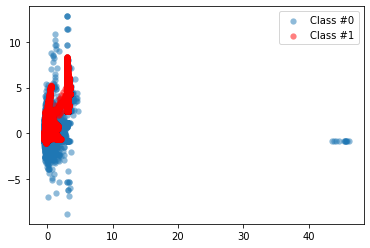

In [274]:
plot_data(X_resampled, y_resampled)

In [275]:
# Construct the logistic Regression and train
logreg = LogisticRegressionCV() #default cv = 5
logreg.fit(X_resampled, y_resampled)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [276]:
y_pred = logreg.predict(X_test)

In [169]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10900  3348]
 [   56   174]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86     14248
           1       0.05      0.76      0.09       230

    accuracy                           0.76     14478
   macro avg       0.52      0.76      0.48     14478
weighted avg       0.98      0.76      0.85     14478



In [277]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10869  3379]
 [   56   174]]
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     14248
           1       0.05      0.76      0.09       230

    accuracy                           0.76     14478
   macro avg       0.52      0.76      0.48     14478
weighted avg       0.98      0.76      0.85     14478



In [278]:
y_pred[y_pred == 1]

array([1, 1, 1, ..., 1, 1, 1])

# Test Submission 

In [280]:
test_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/travel_insurance/Testing_set_label.csv')

In [281]:
test_data.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,EPX,Travel Agency,Online,Cancellation Plan,24,HONG KONG,27.0,0.0,NaN,36
1,EPX,Travel Agency,Online,Cancellation Plan,51,JAPAN,45.0,0.0,NaN,36
2,EPX,Travel Agency,Online,Cancellation Plan,52,JAPAN,21.0,0.0,NaN,21
3,EPX,Travel Agency,Online,Cancellation Plan,89,SINGAPORE,11.0,0.0,NaN,30
4,EPX,Travel Agency,Online,Cancellation Plan,5,MALAYSIA,10.0,0.0,NaN,33


In [282]:
# preprocess test_data
test_data.drop(columns = ['Gender', 'Commision (in value)'  ], inplace = True)

In [283]:
#test_enc = pd.get_dummies(test_data, drop_first = True)
test_enc = pd.get_dummies(test_data, prefix_sep="__", 
                                   columns=cat_columns, drop_first = True)

In [284]:
test_enc.head()

,Duration,Net Sales,Age,Agency__ART,Agency__C2B,Agency__CBH,Agency__CCR,Agency__CSR,Agency__CWT,Agency__EPX,Agency__JWT,Agency__JZI,Agency__KML,Agency__LWC,Agency__RAB,Agency__SSI,Agency__TST,Agency__TTW,Agency Type__Travel Agency,Distribution Channel__Online,Product Name__2 way Comprehensive Plan,Product Name__24 Protect,Product Name__Annual Gold Plan,Product Name__Annual Silver Plan,Product Name__Annual Travel Protect Gold,Product Name__Annual Travel Protect Platinum,Product Name__Annual Travel Protect Silver,Product Name__Basic Plan,Product Name__Bronze Plan,Product Name__Cancellation Plan,Product Name__Child Comprehensive Plan,Product Name__Comprehensive Plan,Product Name__Gold Plan,Product Name__Individual Comprehensive Plan,Product Name__Premier Plan,Product Name__Rental Vehicle Excess Insurance,Product Name__Silver Plan,Product Name__Single Trip Travel Protect Gold,Product Name__Single Trip Travel Protect Platinum,Product Name__Single Trip Travel Protect Silver,...,Destination__OMAN,Destination__PAKISTAN,Destination__PANAMA,Destination__PAPUA NEW GUINEA,Destination__PERU,Destination__PHILIPPINES,Destination__POLAND,Destination__PORTUGAL,Destination__QATAR,Destination__ROMANIA,Destination__RUSSIAN FEDERATION,Destination__RWANDA,Destination__SAUDI ARABIA,Destination__SENEGAL,Destination__SIERRA LEONE,Destination__SINGAPORE,Destination__SLOVENIA,Destination__SOUTH AFRICA,Destination__SPAIN,Destination__SRI LANKA,Destination__SWEDEN,Destination__SWITZERLAND,"Destination__TAIWAN, PROVINCE OF CHINA",Destination__TAJIKISTAN,"Destination__TANZANIA, UNITED REPUBLIC OF",Destination__THAILAND,Destination__TRINIDAD AND TOBAGO,Destination__TUNISIA,Destination__TURKEY,Destination__TURKS AND CAICOS ISLANDS,Destination__UGANDA,Destination__UKRAINE,Destination__UNITED ARAB EMIRATES,Destination__UNITED KINGDOM,Destination__UNITED STATES,Destination__UZBEKISTAN,Destination__VANUATU,Destination__VIET NAM,Destination__ZAMBIA,Destination__ZIMBABWE
0,24,27.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,51,45.0,36,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,52,21.0,21,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,89,11.0,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,10.0,33,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [285]:
test_ready = add_missing_columns(test_enc, cat_dummies= cat_dummies, processed_columns= processed_columns )

Adding missing feature Product Name__Travel Cruise Protect Family
Adding missing feature Destination__ANGOLA
Adding missing feature Destination__ARGENTINA
Adding missing feature Destination__ARMENIA
Adding missing feature Destination__BARBADOS
Adding missing feature Destination__BENIN
Adding missing feature Destination__BHUTAN
Adding missing feature Destination__BOSNIA AND HERZEGOVINA
Adding missing feature Destination__BOTSWANA
Adding missing feature Destination__CAYMAN ISLANDS
Adding missing feature Destination__CHILE
Adding missing feature Destination__DOMINICAN REPUBLIC
Adding missing feature Destination__FRENCH POLYNESIA
Adding missing feature Destination__GUADELOUPE
Adding missing feature Destination__GUATEMALA
Adding missing feature Destination__GUINEA-BISSAU
Adding missing feature Destination__KOREA, DEMOCRATIC PEOPLE'S REPUBLIC OF
Adding missing feature Destination__KYRGYZSTAN
Adding missing feature Destination__LIBYAN ARAB JAMAHIRIYA
Adding missing feature Destination__MALI
A

In [286]:
test_scaled = sc.fit_transform(test_ready)

In [287]:
# predict 
test_pred = logreg.predict(test_scaled)

In [288]:
prediction = pd.DataFrame(test_pred)


In [290]:
prediction.rename(columns = {0:'prediction'}, inplace = True)

In [291]:
prediction

,prediction
0,0
1,0
2,0
3,0
4,0
...,...
15827,0
15828,1
15829,0
15830,0


In [292]:
prediction.to_csv('prediction2.csv', index = False)

In [ ]:
#75	olgab	8.34765529094034